In [ ]:
!pip install transformers datasets peft accelerate bitsandbytes evaluate nltk rouge-score

In [ ]:
# ✅ Step 1: Install dependencies
# If running locally or on Kaggle, install if needed:
# !pip install transformers accelerate datasets peft bitsandbytes evaluate nltk

# ✅ Step 2: Imports
import torch
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling,
    BitsAndBytesConfig
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
import evaluate
import nltk
nltk.download('punkt')

# ✅ Step 3: Load and format dataset using only User + Nutritionist
dataset = load_dataset("Tom158/Nutritional-LLama")

def format_example(example):
    prompt = f"<|user|>\n{example['User']}\n<|assistant|>\n{example['Nutritionist']}"
    return {"text": prompt}

dataset = dataset.map(format_example)
train_dataset = dataset["train"].shuffle(seed=42).select(range(200))
eval_dataset = dataset["train"].select(range(200, 250))

# ✅ Step 4: Load tokenizer and quantized model
model_name = "Qwen/Qwen2.5-3B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=quant_config,
    device_map="auto",
    trust_remote_code=True
)

model = prepare_model_for_kbit_training(model)

# ✅ Step 5: Apply LoRA
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"
)
model = get_peft_model(model, lora_config)

# ✅ Step 6: Tokenization
def tokenize(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=512)

train_dataset = train_dataset.map(tokenize, batched=True)
eval_dataset = eval_dataset.map(tokenize, batched=True)

# ✅ Step 7: TrainingArguments
training_args = TrainingArguments(
    output_dir="./lora-nutrition",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    num_train_epochs=1,
    logging_steps=10,
    learning_rate=2e-4,
    bf16=True,  # Better than fp16 for quantized models
    save_total_limit=2,
    report_to="none"
)

# ✅ Step 8: Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)
)

# ✅ Step 9: Train
trainer.train()

# ✅ Step 10: Save
model.save_pretrained("./lora-nutrition")
tokenizer.save_pretrained("./lora-nutrition")


2025-04-19 19:22:27.938117: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745090547.960553     188 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745090547.967349     188 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

/tmp/ipykernel_188/3011452871.py:85: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args

Step,Training Loss
10,1.924900
20,1.742700


('./lora-nutrition/tokenizer_config.json',
 './lora-nutrition/special_tokens_map.json',
 './lora-nutrition/vocab.json',
 './lora-nutrition/merges.txt',
 './lora-nutrition/added_tokens.json',
 './lora-nutrition/tokenizer.json')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset

import nltk
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.manifold import TSNE
from sentence_transformers import SentenceTransformer
import networkx as nx

nltk.download('punkt')
nltk.download('stopwords')

import torch
from transformers import (AutoProcessor, AutoModelForVision2Seq,
    AutoModelForCausalLM, AutoTokenizer, TrainingArguments, Trainer)
from transformers.integrations import TensorBoardCallback
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from PIL import Image
import requests
from transformers import LlavaForConditionalGeneration

from evaluate import load
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Add OCR capabilities
import pytesseract
from PIL import Image

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
dataset = load_dataset("Tom158/Nutritional-LLama")
df = dataset['train'].to_pandas()
print(df.columns, df.shape)

Index(['System', 'User', 'Nutritionist', 'text'], dtype='object') (1488, 4)


In [ ]:
class NutritionNLPProcessor:
    def __init__(self):
        self.nlp = spacy.load('en_core_web_sm')
        self.stop_words = set(stopwords.words('english'))
        self.embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
    def preprocess_text(self, text):
        text = text.lower()
        tokens = word_tokenize(text)
        return [token for token in tokens if token.isalnum() and token not in self.stop_words]
    def perform_pos_tagging(self, text):
        doc = self.nlp(text)
        pos_distribution = {}
        for token in doc:
            pos_distribution[token.pos_] = pos_distribution.get(token.pos_, 0) + 1
        return pos_distribution
    def visualize_embeddings_tsne(self, texts, top_n=30):
        from sklearn.manifold import TSNE
        import matplotlib.pyplot as plt

        # Tokenize and flatten, then deduplicate
        tokens = [w for text in texts for w in self.preprocess_text(text)]
        unique_tokens = list(set(tokens))[:top_n]

        if len(unique_tokens) < 4:
            raise ValueError("Need at least 4 unique tokens for meaningful t-SNE visualization.")

        # Generate embeddings for selected tokens
        embeddings = self.embedding_model.encode(unique_tokens)

        # Set perplexity to something safe
        perplexity = min(len(embeddings) - 1, 30)
        tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)

        # Project to 2D
        embeddings_2d = tsne.fit_transform(embeddings)

        # Plot
        plt.figure(figsize=(12, 8))
        plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])

        # Annotate points
        for i, token in enumerate(unique_tokens):
            plt.annotate(token, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=9)

        plt.title("t-SNE Visualization of Word Embeddings")
        plt.show()


In [ ]:
class PromptEngineeringTechniques:
    def chain_of_thought(self, query=None):
        formatted_instruction = "Reason through the problem step by step, ensuring each step logically follows from the last."
        return formatted_instruction

    def tree_of_thought(self, query=None):
        formatted_instruction = "Explore multiple reasoning paths in parallel, compare their outcomes, and choose the most plausible one."
        return formatted_instruction

    def graph_of_thought(self, query=None):
        formatted_instruction = "Map out and connect relevant ideas to form a structured, interconnected explanation."
        return formatted_instruction

In [ ]:
class RetrievalAugmentedGeneration:
    def __init__(self, texts, use_lora=True, lora_path="./lora-nutrition", base_model="Qwen/Qwen2.5-3B-Instruct"):
        self.embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
        self.texts = texts
        self.embeddings = self.embedding_model.encode(texts, convert_to_tensor=True).cpu().numpy()
        import faiss
        dimension = self.embeddings.shape[1]
        self.index = faiss.IndexHNSWFlat(dimension, 32)
        self.index.add(self.embeddings)

        # Use the fine-tuned LoRA model if available
        if use_lora:
            try:
                print(f"Loading fine-tuned LoRA model from {lora_path}...")
                self.model_id = base_model

                # Load tokenizer from the LoRA path
                self.tokenizer = AutoTokenizer.from_pretrained(lora_path, trust_remote_code=True)
                self.tokenizer.pad_token = self.tokenizer.eos_token

                # Configure quantization for 4-bit loading
                quant_config = BitsAndBytesConfig(
                    load_in_4bit=True,
                    bnb_4bit_use_double_quant=True,
                    bnb_4bit_quant_type="nf4",
                    bnb_4bit_compute_dtype=torch.bfloat16,
                )

                # Load base model with quantization
                self.model = AutoModelForCausalLM.from_pretrained(
                    self.model_id,
                    quantization_config=quant_config,
                    device_map="auto",
                    trust_remote_code=True
                )

                # Load LoRA adapter
                from peft import PeftModel
                self.model = PeftModel.from_pretrained(self.model, lora_path)
                print("Successfully loaded Qwen LoRA model")
            except Exception as e:
                print(f"Error loading LoRA model: {str(e)}. Falling back to default model.")
                # Fall back to default model
                self.model_id = "Qwen/Qwen2.5-3B-Instruct"
                self.model = AutoModelForCausalLM.from_pretrained(
                    self.model_id,
                    torch_dtype="auto",
                    device_map="auto",
                    trust_remote_code=True
                )
                self.tokenizer = AutoTokenizer.from_pretrained(self.model_id, trust_remote_code=True)
                if self.tokenizer.pad_token is None:
                    self.tokenizer.pad_token = self.tokenizer.eos_token
        else:
            # Use default model
            self.model_id = "Qwen/Qwen2.5-3B-Instruct"
            self.model = AutoModelForCausalLM.from_pretrained(
                self.model_id,
                torch_dtype="auto",
                device_map="auto",
                trust_remote_code=True
            )
            self.tokenizer = AutoTokenizer.from_pretrained(self.model_id, trust_remote_code=True)
            if self.tokenizer.pad_token is None:
                self.tokenizer.pad_token = self.tokenizer.eos_token

    def retrieve_relevant_context(self, query, top_k=3):
        q_emb = self.embedding_model.encode([query], convert_to_tensor=True).cpu().numpy()
        distances, indices = self.index.search(q_emb, top_k)
        return [self.texts[i] for i in indices[0]]

    def generate_response(self, query, image_path=None, top_k=3, reasoning_technique=None, reasoning_params=None):
        contexts = self.retrieve_relevant_context(query, top_k)
        context = "\n".join(contexts)

        image_text = ""
        if image_path:
            try:
                image = Image.open(image_path)
                image_text = pytesseract.image_to_string(image)
                query = f"Image contains: {image_text}\n\n{query}"
            except Exception as e:
                print(f"Error processing image: {str(e)}")

        # Add reasoning technique to the prompt if specified
        reasoning_instruction = ""
        if reasoning_technique and hasattr(PromptEngineeringTechniques(), reasoning_technique):
            technique_method = getattr(PromptEngineeringTechniques(), reasoning_technique)
            reasoning_instruction = technique_method(query)

        # Format prompt based on the model's expected format
        # Qwen models use a chat format that we need to adapt to
        if "qwen" in self.model_id.lower():
            # Format for Qwen chat model
            prompt = f"<|user|>\nContext:\n{context}\n\n"
            if reasoning_instruction:
                prompt += f"{reasoning_instruction}\n\n"
            prompt += f"Question: {query}\n<|assistant|>\n"
        else:
            # Format for other models
            prompt = f"Context:\n{context}\n\n"
            if reasoning_instruction:
                prompt += f"{reasoning_instruction}\n\n"
            prompt += f"Question: {query}\n\nAnswer:"

        # Generate response from LLM
        inputs = self.tokenizer(prompt, return_tensors="pt", padding=True).to("cuda" if torch.cuda.is_available() else "cpu")

        # Check input length and truncate if necessary
        if inputs["input_ids"].shape[1] > 500:
            print(f"Warning: Input length is {inputs['input_ids'].shape[1]}, truncating context")
            shortened_context = context.split("\n")[0]

            if "qwen" in self.model_id.lower():
                prompt = f"<|user|>\nContext:\n{shortened_context}\n\nQuestion: {query}\n<|assistant|>\n"
            else:
                prompt = f"Context:\n{shortened_context}\n\nQuestion: {query}\n\nAnswer:"

            inputs = self.tokenizer(prompt, return_tensors="pt", padding=True).to("cuda" if torch.cuda.is_available() else "cpu")

        outputs = self.model.generate(
            **inputs,
            max_new_tokens=512,
            do_sample=True,
            top_p=0.95,
            temperature=0.7
        )
        response = self.tokenizer.decode(outputs[0], skip_special_tokens=True)

        # Extract just the answer part if possible
        if "qwen" in self.model_id.lower():
            if "<|assistant|>" in response:
                response = response.split("<|assistant|>")[-1].strip()
        else:
            if "Answer:" in response:
                response = response.split("Answer:")[-1].strip()

        return response

In [ ]:
class MultimodalNutritionAgent:
    def __init__(self, rag_system, nlp_processor):
        self.rag_system = rag_system
        self.nlp_processor = nlp_processor
        self.prompt_engineering = PromptEngineeringTechniques()

    def process_text_query(self, query, reasoning_technique=None):
        reasoning_params = None
        if reasoning_technique == "graph_of_thought":
            tokens = self.nlp_processor.preprocess_text(query)
            key_concepts = tokens[:5] if len(tokens) > 5 else tokens
            reasoning_params = key_concepts

        response = self.rag_system.generate_response(
            query,
            reasoning_technique=reasoning_technique,
            reasoning_params=reasoning_params
        )
        return {"response": response, "reasoning_technique": reasoning_technique}

    def analyze_food_image(self, image_path):
        try:
            image = Image.open(image_path).convert('RGB')
            extracted_text = pytesseract.image_to_string(image)

            nutritional_info = {}
            if "calories" in extracted_text.lower():
                nutritional_info["calories_mentioned"] = True

            return {
                "image_size": image.size,
                "format": image.format,
                "extracted_text": extracted_text,
                "nutritional_info": nutritional_info
            }
        except Exception as e:
            return {"error": str(e)}

    def process_image_query(self, image_path, text_query=None, reasoning_technique=None):
        image_info = self.analyze_food_image(image_path)

        if text_query is None:
            text_query = "Provide nutritional information about this food."

        if "extracted_text" in image_info and image_info["extracted_text"]:
            enhanced_query = f"{text_query} The image contains text: {image_info['extracted_text']}"
        else:
            enhanced_query = text_query

        reasoning_params = None
        if reasoning_technique == "graph_of_thought":
            tokens = self.nlp_processor.preprocess_text(enhanced_query)
            key_concepts = tokens[:5] if len(tokens) > 5 else tokens
            reasoning_params = key_concepts

        response = self.rag_system.generate_response(
            enhanced_query,
            image_path=image_path,
            reasoning_technique=reasoning_technique,
            reasoning_params=reasoning_params
        )
        return {"response": response, "image_info": image_info, "reasoning_technique": reasoning_technique}

    def recommend_meal_by_image(self, image_path, dietary_preference=None, health_goal=None, reasoning_technique="chain_of_thought"):
        query = "Based on this image"
        if dietary_preference:
            query += f", with dietary preference {dietary_preference}"
        if health_goal:
            query += f", aiming for {health_goal}"
        query += ", provide nutritional recommendations."

        response = self.process_image_query(image_path, query, reasoning_technique=reasoning_technique)
        return response

In [ ]:
class EvaluationFramework:
    def __init__(self):
        self.bleu = load("bleu")
        self.rouge = load("rouge")
        self.embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
    def evaluate_text_generation(self, predictions, references):
        bleu_results = self.bleu.compute(predictions=predictions, references=references)
        rouge_results = self.rouge.compute(predictions=predictions, references=references)
        return {"bleu": bleu_results, "rouge": rouge_results}
    def evaluate_semantic_similarity(self, predictions, references):
        pred_emb = self.embedding_model.encode(predictions)
        ref_emb = self.embedding_model.encode(references)
        similarities = [np.dot(p, r)/(np.linalg.norm(p)*np.linalg.norm(r)) for p, r in zip(pred_emb, ref_emb)]
        return {"average": sum(similarities)/len(similarities), "scores": similarities}
    def evaluate_rag_system(self, rag_system, test_queries, ground_truth_responses):
        responses = [rag_system.generate_response(q) for q in test_queries]
        text_metrics = self.evaluate_text_generation(responses, ground_truth_responses)
        semantic_scores = self.evaluate_semantic_similarity(responses, ground_truth_responses)
        return {"text_metrics": text_metrics, "semantic": semantic_scores}

In [ ]:
!pip install faiss-cpu

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 53.6 MB/s eta 0:00:00:00:0100:01


In [ ]:
texts = df['text'].tolist()
rag = RetrievalAugmentedGeneration(
    texts,
    use_lora=True,
    lora_path="./lora-nutrition",
    base_model="Qwen/Qwen2.5-3B-Instruct"
)
nlp_processor = NutritionNLPProcessor()
agent = MultimodalNutritionAgent(rag, nlp_processor)

Batches:   0%|          | 0/47 [00:00<?, ?it/s]

Loading fine-tuned LoRA model from ./lora-nutrition...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Successfully loaded Qwen LoRA model


In [ ]:
print("\n===== Testing LoRA-Enhanced Nutritional Agent with Qwen2.5 =====\n")

response_cot = agent.process_text_query("What are the health benefits of avocados?", reasoning_technique="chain_of_thought")
print("\nChain of Thought Response:")
print(response_cot["response"])
print("\n" + "="*50)


===== Testing LoRA-Enhanced Nutritional Agent with Qwen2.5 =====



Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Chain of Thought Response:
Context:
There is no one-size-fits-all answer to this question, as everyone's dietary needs and preferences are different. However, incorporating avocados into your diet in various forms can be a great way to reap their health benefits. You could try adding them to salads, sandwiches, or smoothies, or using them as a dip or spread with whole-grain crackers or pita bread. You could also use avocado oil instead of other oils when cooking or baking. As always, it's important to remember to consume avocados in moderation as they are high in calories. <|user|>
That's great advice! Do you have any tips on how to choose ripe avocados at the store? <



In [ ]:
response_got = agent.process_text_query("How do proteins, fats, and carbohydrates work together?", reasoning_technique="graph_of_thought")
print("\nGraph of Thought Response:")
print(response_got["response"])
print("\n" + "="*50)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Graph of Thought Response:
Incorporating healthy fats into your diet doesn't have to be complicated. Here are a few simple ways to start:

1. Avocado: Add slices or guacamole to your sandwiches, salads, or wraps.
2. Nuts and Seeds: Snack on nuts, seeds, or a handful of dried fruit.
3. Olive Oil: Use it for cooking, baking, or as a salad dressing.
4. Chia Seeds: Sprinkle them on oatmeal, smoothies, or yogurt.



In [ ]:
from collections import Counter

# Create an empty Counter to store POS counts for the entire dataset
all_pos_counts = Counter()

# Iterate over each row of the dataset (assuming df['text'] contains the text data)
for text in df['text']:
    pos_results = nlp_processor.perform_pos_tagging(text)

    # Update the overall POS counts for this example
    all_pos_counts.update(pos_results)

# Display the overall POS distribution for the entire dataset
print("POS Distribution for the entire dataset:")
for pos, count in sorted(all_pos_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"  {pos}: {count}")
print("\n" + "-"*50)


POS Distribution for the entire dataset:
  NOUN: 55035
  VERB: 30327
  ADJ: 29944
  PUNCT: 27557
  X: 26794
  PRON: 26295
  ADP: 21939
  AUX: 18080
  DET: 16430
  CCONJ: 10341
  ADV: 6752
  PART: 6343
  SPACE: 4767
  SCONJ: 4332
  PROPN: 2462
  NUM: 1015
  INTJ: 262
  SYM: 20

--------------------------------------------------



3. Visualizing Word Embeddings from Dataset with t-SNE:


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

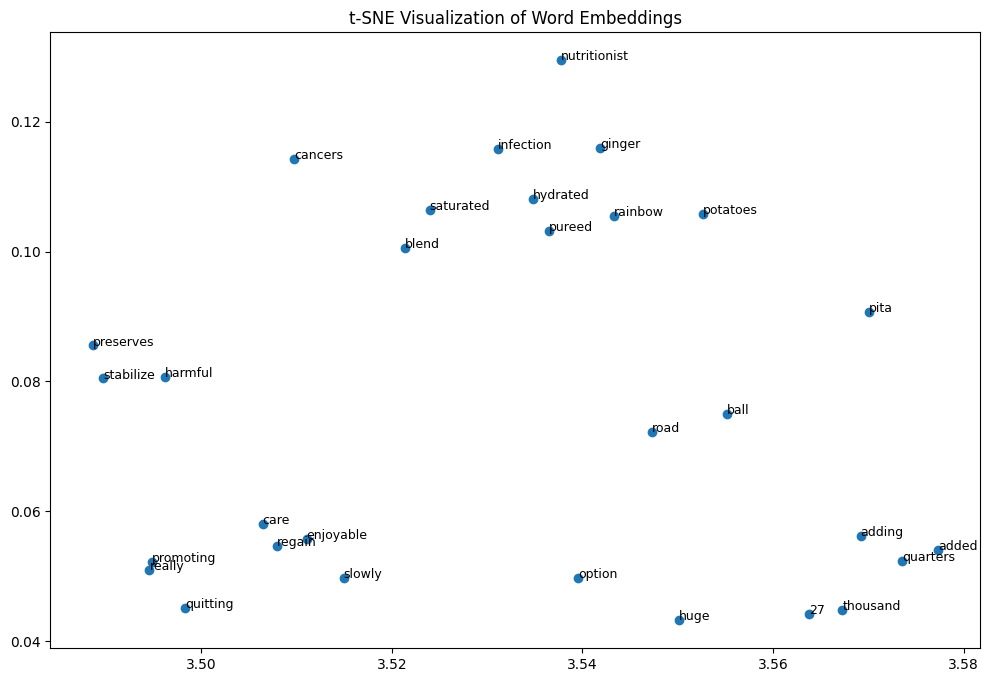

Visualization completed. Check the plot window.


In [ ]:
print("\n3. Visualizing Word Embeddings from Dataset with t-SNE:")
# Select a reasonable number of examples to avoid memory issues
dataset_viz_samples = df['text'].iloc[:].tolist()
nlp_processor.visualize_embeddings_tsne(dataset_viz_samples, top_n=30)
print("Visualization completed. Check the plot window.")

In [ ]:
test_queries = df['User'].iloc[:3].tolist()


In [ ]:
responses = []
for i, query in enumerate(test_queries):
    # Use query excerpt for display if too long
    display_query = query[:80] + "..." if len(query) > 80 else query

    # Alternate reasoning techniques
    reasoning_technique = ["chain_of_thought", "graph_of_thought", "tree_of_thought"][i % 3]

    print(f"Query {i+1}: '{display_query}' (using {reasoning_technique})")
    response = agent.process_text_query(query, reasoning_technique=reasoning_technique)
    responses.append(response["response"])
    print(f"Response: '{response['response'][:100]}...'")
    print("-"*30)
print("\n" + "-"*50)

Query 1: 'I've been trying to lose some weight and get in shape, but I love ground lean as...' (using chain_of_thought)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Response: 'Context:
<s>
Absolutely! Here are a few ideas for incorporating ground lean into your meals:

1. Bre...'
------------------------------
Query 2: 'Can I still enjoy artichokes despite having heart disease, or will it worsen my ...' (using graph_of_thought)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Response: 'The amount of vegetables you should eat per day depends on your individual caloric needs and overall...'
------------------------------
Query 3: 'What are the best ways to incorporate dandelion greens into my diet, considering...' (using tree_of_thought)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Response: 'Context:
<s>
While all the...'
------------------------------

--------------------------------------------------


In [ ]:
test_indices = np.random.choice(len(df), min(5, len(df)), replace=False)
test_examples = []
for idx in test_indices:
    test_examples.append({
        "user_query": df['User'].iloc[idx],
        "reference_response": df['Nutritionist'].iloc[idx],
        "index": idx
    })
print(f"Selected {len(test_examples)} User/Nutritionist pairs from dataset")

Selected 5 User/Nutritionist pairs from dataset


In [ ]:
evaluator = EvaluationFramework()

for i, example in enumerate(test_examples):
    print(f"\nProcessing example {i+1}/{len(test_examples)}:")

    query = example["user_query"]
    reference = example["reference_response"]

    # Truncate for display if needed
    display_query = query[:80] + "..." if len(query) > 80 else query
    print(f"Query: '{display_query}'")



    # 3.2. Generate responses with different reasoning techniques
    reasoning_techniques = ["chain_of_thought", "graph_of_thought", "tree_of_thought"]
    technique_results = {}

    for technique in reasoning_techniques:
        print(f"\nGenerating response using {technique}:")
        response_data = agent.process_text_query(query, reasoning_technique=technique)
        response = response_data["response"]

        # Truncate for display
        display_response = response[:100] + "..." if len(response) > 100 else response
        print(f"Response: '{display_response}'")

        # 3.3. Evaluate this specific response against reference
        # Calculate individual metrics for this response
        bleu_score = evaluator.bleu.compute(predictions=[response], references=[[reference]])["bleu"]
        rouge_scores = evaluator.rouge.compute(predictions=[response], references=[reference])

        # Calculate semantic similarity
        response_emb = evaluator.embedding_model.encode([response])[0]
        reference_emb = evaluator.embedding_model.encode([reference])[0]
        similarity = np.dot(response_emb, reference_emb) / (np.linalg.norm(response_emb) * np.linalg.norm(reference_emb))

        print(f"Evaluation metrics:")
        print(f"  BLEU: {bleu_score:.4f}")
        print(f"  ROUGE-1: {rouge_scores['rouge1']:.4f}")
        print(f"  Semantic similarity: {similarity:.4f}")

        # Store results for this technique
        technique_results[technique] = {
            "response": response,
            "bleu": bleu_score,
            "rouge1": rouge_scores['rouge1'],
            "rouge2": rouge_scores['rouge2'],
            "rougeL": rouge_scores['rougeL'],
            "similarity": similarity
        }

    # Find best technique for this example
    best_technique = max(technique_results.items(), key=lambda x: x[1]["similarity"])[0]

    print(f"\nBest reasoning technique for this example: {best_technique}")
    print(f"Best semantic similarity score: {technique_results[best_technique]['similarity']:.4f}")


Processing example 1/5:
Query: 'I'm trying to incorporate more healthy fats into my diet as a 76-year-old with h...'

Generating response using chain_of_thought:


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Response: 'Context:
[s] Based on the assistant's response, what are the potential benefits and drawbacks of inc...'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluation metrics:
  BLEU: 0.0422
  ROUGE-1: 0.2825
  Semantic similarity: 0.8423

Generating response using graph_of_thought:


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Response: '<s>[INST] >

Of course! Here are a few recipes that you might enjoy incorporating safflower seed oil...'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluation metrics:
  BLEU: 0.0000
  ROUGE-1: 0.1636
  Semantic similarity: 0.5117

Generating response using tree_of_thought:


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Response: 'Context:
<s>[INST] <<SYS>>
<s>
Yes, there are several ways to add healthy fats to your diet. Here ar...'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluation metrics:
  BLEU: 0.0000
  ROUGE-1: 0.2549
  Semantic similarity: 0.5125

Best reasoning technique for this example: chain_of_thought
Best semantic similarity score: 0.8423

Processing example 2/5:
Query: 'Should I be concerned about eating cream cheese considering my history of heart ...'

Generating response using chain_of_thought:


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Response: 'Absolutely! Here’s a simple recipe for making'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluation metrics:
  BLEU: 0.0000
  ROUGE-1: 0.0472
  Semantic similarity: 0.1926

Generating response using graph_of_thought:


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Response: 'Context:
[solved]
You're welcome! Remember that making small changes can add up to big benefits. Goo...'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluation metrics:
  BLEU: 0.0000
  ROUGE-1: 0.2609
  Semantic similarity: 0.6191

Generating response using tree_of_thought:


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Response: 'Context:
[solved]
Answer: Yes, there are several benefits to using coconut oil for skin care. Coconu...'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluation metrics:
  BLEU: 0.0000
  ROUGE-1: 0.1854
  Semantic similarity: 0.2402

Best reasoning technique for this example: graph_of_thought
Best semantic similarity score: 0.6191

Processing example 3/5:
Query: 'Should I be worried about consuming crab meat when I'm trying to lose weight and...'

Generating response using chain_of_thought:


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Response: 'Context:
[s]
<s>[INST] <<SYS>>
Answer: Crab meat is a great source of protein and can be a'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluation metrics:
  BLEU: 0.0000
  ROUGE-1: 0.1472
  Semantic similarity: 0.5786

Generating response using graph_of_thought:


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Response: 'Context:
[s]
<s>[INST] <<SYS>>
<s>[INST] Context:
[USER]
You're a nutritionist. Based on the informa...'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluation metrics:
  BLEU: 0.0000
  ROUGE-1: 0.1919
  Semantic similarity: 0.3064

Generating response using tree_of_thought:


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Response: 'Context:
[s6]

To summarize, consuming crab meat in moderation as part of a balanced diet can be a g...'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluation metrics:
  BLEU: 0.0000
  ROUGE-1: 0.2077
  Semantic similarity: 0.7828

Best reasoning technique for this example: tree_of_thought
Best semantic similarity score: 0.7828

Processing example 4/5:
Query: 'Should I still consider peanuts as a healthy snack option despite being anemic a...'

Generating response using chain_of_thought:


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Response: 'Certainly! There are many calorie-dense foods that you can incorporate into your diet to help'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluation metrics:
  BLEU: 0.0000
  ROUGE-1: 0.1268
  Semantic similarity: 0.5277

Generating response using graph_of_thought:


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Response: 'Certainly! Here's a simple recipe for trail mix that is packed with nutrients and has a variety of f...'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluation metrics:
  BLEU: 0.0000
  ROUGE-1: 0.2194
  Semantic similarity: 0.3115

Generating response using tree_of_thought:


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Response: 'provide for someone who is anemic and underweight? Please elaborate.
<|user|>
When considering peanu...'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluation metrics:
  BLEU: 0.0000
  ROUGE-1: 0.3249
  Semantic similarity: 0.7714

Best reasoning technique for this example: tree_of_thought
Best semantic similarity score: 0.7714

Processing example 5/5:
Query: 'I've been trying to increase my fiber intake and whole-wheat bread seems like a ...'

Generating response using chain_of_thought:


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Response: 'Context:
[s]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluation metrics:
  BLEU: 0.0000
  ROUGE-1: 0.0000
  Semantic similarity: -0.1245

Generating response using graph_of_thought:


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Response: 'Certainly! There are many gluten-free options available that can be used as a substitute for whole w...'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluation metrics:
  BLEU: 0.0375
  ROUGE-1: 0.2520
  Semantic similarity: 0.6616

Generating response using tree_of_thought:


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Response: '[s]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluation metrics:
  BLEU: 0.0000
  ROUGE-1: 0.0000
  Semantic similarity: -0.1360

Best reasoning technique for this example: graph_of_thought
Best semantic similarity score: 0.6616


In [ ]:
!pip install gradio

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 36.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 102.4 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.3 MB/s eta 0:00:00


In [ ]:
import gradio as gr

def process_nutrition_query(query_text, reasoning_technique):
    """Process a text-based nutrition query"""
    result = agent.process_text_query(query_text, reasoning_technique=reasoning_technique)
    return result["response"]

def process_food_image(image, prompt, reasoning_technique):
    """Process a food image with OCR and send the extracted text to the model"""
    try:
        # Save the image temporarily
        temp_image_path = "temp_food_image.jpg"
        if image is not None:
            image.save(temp_image_path)
        else:
            return "Error: No image provided"

        # Extract text from image using OCR
        extracted_text = ""
        try:
            img = Image.open(temp_image_path).convert('RGB')
            extracted_text = pytesseract.image_to_string(img)
            if not extracted_text.strip():
                extracted_text = "No text detected in image. This appears to be a food item."
        except Exception as e:
            return f"OCR error: {str(e)}"

        # Create a query that includes the OCR text and user prompt
        if prompt and prompt.strip():
            query = f"{prompt} OCR detected text: {extracted_text}"
        else:
            query = f"Analyze this food item. OCR detected text: {extracted_text}"

        # Process the query with the selected reasoning technique
        result = agent.process_text_query(query, reasoning_technique=reasoning_technique)

        # Return the response with OCR info
        return f"OCR detected: {extracted_text}\n\nAnalysis:\n{result['response']}"
    except Exception as e:
        return f"Error processing image: {str(e)}"

# Create a simplified Gradio interface
def create_simple_nutrition_ui():
    with gr.Blocks(title="Nutritional Analysis AI") as demo:
        gr.Markdown("# Nutritional Analysis AI")
        gr.Markdown("Analyze food items with text queries or images using different reasoning techniques")

        with gr.Tab("Text Query"):
            text_input = gr.Textbox(label="Nutrition Question", placeholder="Ask a nutrition-related question...", lines=3)
            text_reasoning = gr.Dropdown(
                choices=["chain_of_thought", "graph_of_thought", "tree_of_thought"],
                label="Reasoning Technique",
                value="chain_of_thought"
            )
            text_submit = gr.Button("Get Answer")
            text_output = gr.Textbox(label="AI Response", lines=10)

            text_submit.click(
                process_nutrition_query,
                inputs=[text_input, text_reasoning],
                outputs=text_output
            )

        with gr.Tab("Food Image Analysis"):
            image_input = gr.Image(label="Upload Food Image", type="pil")
            prompt_input = gr.Textbox(label="Custom Prompt (Optional)",
                                     placeholder="E.g., Is this food healthy? What nutrients does it contain?",
                                     lines=2)
            image_reasoning = gr.Dropdown(
                choices=["chain_of_thought", "graph_of_thought", "tree_of_thought"],
                label="Reasoning Technique",
                value="chain_of_thought"
            )
            image_submit = gr.Button("Scan & Analyze")
            image_output = gr.Textbox(label="OCR & Analysis", lines=15)

            image_submit.click(
                process_food_image,
                inputs=[image_input, prompt_input, image_reasoning],
                outputs=image_output
            )

    return demo

# Run the Gradio app when file is executed
if __name__ == "__main__":
    # Initialize our models
    texts = df['text'].tolist()
    rag = RetrievalAugmentedGeneration(
        texts,
        use_lora=True,
        lora_path="./lora-nutrition",
        base_model="Qwen/Qwen2.5-3B-Instruct"
    )
    nlp_processor = NutritionNLPProcessor()
    agent = MultimodalNutritionAgent(rag, nlp_processor)

    # Create and launch the simplified Gradio interface
    print("Starting Nutritional Analysis UI...")
    demo = create_simple_nutrition_ui()
    demo.launch(share=True)

Batches:   0%|          | 0/47 [00:00<?, ?it/s]

Loading fine-tuned LoRA model from ./lora-nutrition...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Successfully loaded Qwen LoRA model
Starting Nutritional Analysis UI...
* Running on local URL:  http://127.0.0.1:7861
* Running on public URL: https://930e54c34fb27c9390.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]